In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/Khoa Luan/"

In [3]:
import pickle
import pandas as pd
df = pd.read_csv(path+"data3.csv")
df_test = pd.read_csv(path+'test3.csv')
df_test = df_test.dropna()
df = df.dropna()

In [4]:
data_train = df.review.to_list()
label_train = df.label.to_list()
data_test = df_test.review.tolist()
label_test = df_test.label.tolist()

In [5]:
!pip install -q keras-bert==0.85.0
!pip install -q keras-rectified-adam

In [6]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
pip install keras==2.3.1

     |████████████████████████████████| 378kB 5.2MB/s 
ERROR: keras-bert 0.85.0 has requirement Keras>=2.4.3, but you'll have keras 2.3.1 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [8]:
import codecs
import tensorflow as tf
import keras
import os
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import numpy as np

Using TensorFlow backend.


In [9]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [10]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [11]:
SEQ_LEN = 256

In [12]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    seq_len=SEQ_LEN,
    output_layer_num=4,
    trainable=True
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
import keras_bert
from keras.layers import Dense, Input, Flatten,SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout,GlobalMaxPool1D,Lambda
from keras.models import Model
from keras.layers import Bidirectional,LSTM,GRU

In [14]:
LR=2e-5

In [15]:
class NonMasking(keras.layers.Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        # do not pass the mask to the next layers   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape  

In [16]:
inputs = model.inputs
bert_out = NonMasking()(model.outputs)

bert_out = SpatialDropout1D(0.2)(bert_out)

l_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
                                                      x[:, :-1]], axis=1))(bert_out)
        
r_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
                                                      x[:, 1:]], axis=1))(bert_out)

forward = LSTM(256, return_sequences=True)(l_embedding) 
backward = LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)
backward = Lambda(lambda x: K.reverse(x, axes=1))(backward)

together = [forward, bert_out , backward]

together = Concatenate(axis=2)(together)

semantic = Conv1D(256, kernel_size=1, activation="relu")(together)
sentence_embed = Lambda(lambda x: K.max(x, axis=1))(semantic)

dense_layer = Dense(256, activation='relu')(sentence_embed)
preds = Dense(1, activation='sigmoid')(dense_layer)
model1 = Model(inputs, preds)

In [17]:
model1.compile(loss='binary_crossentropy',
              optimizer=RAdam(learning_rate=LR),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
token_dict = {}
with codecs.open(vocab_path, 'rb','utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [19]:
from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict,cased=True)

In [20]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)

    return [indices, np.zeros_like(indices)], np.array(sentiments)

In [21]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

In [22]:
data_train_,data_valid,label_train_,label_valid = train_test_split(data_train,label_train,test_size=0.15,random_state=48)

In [23]:
X_train,Y_train = load_data(data_train_,label_train_)
X_valid,Y_valid = load_data(data_valid,label_valid)
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
from keras.callbacks import ModelCheckpoint 
checkpoint = ModelCheckpoint(path+'256_checkpoint_rcnn2_data1.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model1.fit(X_train,Y_train,epochs=10,batch_size=16,verbose = 1,validation_data=[X_valid,Y_valid],callbacks=callbacks_list)       

In [24]:
model1.load_weights(path+'256_checkpoint_rcnn2_data1.h5')

In [25]:
y_pred = np.round(model1.predict(X_test))

In [26]:
from sklearn.metrics import precision_score,recall_score,f1_score
print(precision_score(Y_test,y_pred))
print(recall_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred))

0.8708920187793427
0.8938682086495603
0.8822305451518935


In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cn = confusion_matrix(Y_test,y_pred,labels=labels)

In [28]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()
    

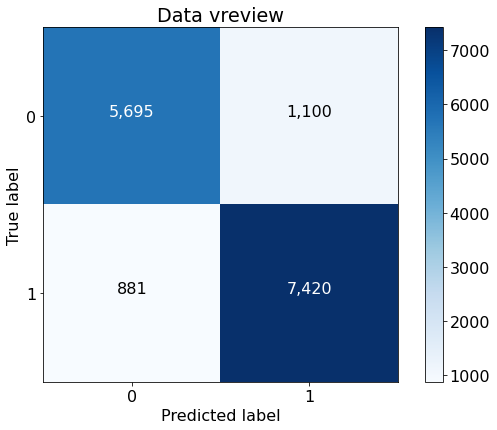

In [29]:
plot_confusion_matrix(cn,title='Data vreview',normalize=False,target_names=labels,path_file=path+'bert_rcnn_vreview_cm.svg')

In [ ]:
for i in range(1000):
  if y_pred[i]!=Y_test[i]:
    print(y_pred[i],Y_test[i])
    print(data_test[i])

[0.] 1
da di han ngay mua gio roi moi chup feedback lai chan minh di nhung thay co ban bao co be nen lay vua positive in luon di luc bi negative ti vao got nhung minh thay da so giay nao moi di cung the so voi gia la qua dep positive roi
[0.] 1
phí giao hàng quá đắt
[1.] 0
chả có hộp hiếc đàng_hoàng gì có mỗi cây_son tưởng đóng_hộp đẹp positive lắm
[1.] 0
thoi gian giao hang rat nhanh dung ngua negative voi len mun
[1.] 0
chua hai long positive voi san pham
[0.] 1
không hổ_danh là đầu_đàn của android thích positive nhất dòng không của ss
[0.] 1
mình mua cái màu xanh dương cửa_hàng gởi cho mình xanh dương xanh lá mình không hài_lòng
[0.] 1
hàng thất_lạc không nhận được positive sản_phẩm cửa_hàng nhé buồn negative vận_chuyển
[0.] 1
san pham bi negative loi day bi negative hong negative ngay sau khi deo vao tay
[0.] 1
hàng bị negative lỗi negative da bong tróck muốn trả hàng chỉ muốn đổi đôi khác chất xong cửa_hàng cho đổi vì_vậy mình mới xác_nhận đã nhận được positive hàng ai_ngờ hôm sau